100%|██████████| 1000/1000 [14:42<00:00,  1.13it/s]


到达最大迭代次数，此时变化值为139.345046


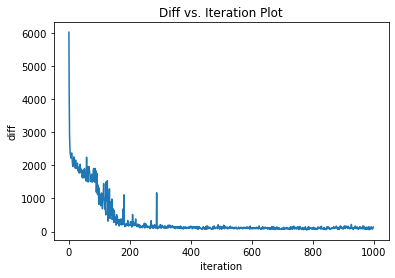

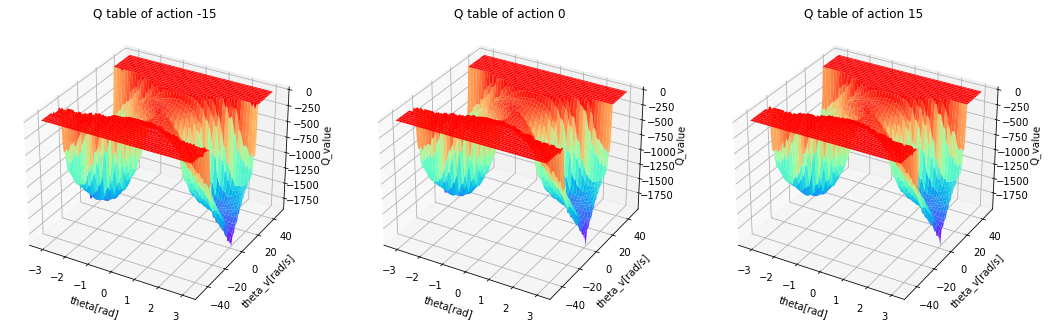

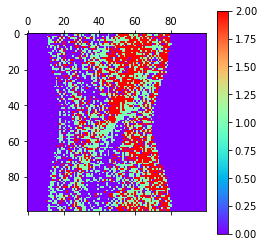

In [2]:
import numpy as np
# from myenv import MyEnv
import math
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

class CartPoleSolver():
    
    def __init__(self, gamma=0.98, epsilon=0.99, alpha=0.25, episodes=1000, batch_size=20000, interval_num=100, error=1e-2):
        self.env = MyEnv()
        self.gamma = gamma # 折扣因子
        self.epsilon = epsilon # 贪婪策略参数
        self.alpha = alpha # 学习率
        self.episodes = episodes # 决策序列长度
        self.batch_size = batch_size # 训练次数
        self.interval_num = interval_num # 连续变量转离散变量分为几段
        self.error = error
        self.error_table = []

        self.pa_bin = np.linspace(-math.pi, math.pi, interval_num+1)[1: -1]
        self.pv_bin = np.linspace(-math.pi*15, math.pi*15, interval_num+1)[1: -1]

        # self.q_table = np.random.uniform(low=0, high=1, size=(interval_num**2, 3))
        self.q_table = np.zeros((interval_num**2, 3), dtype= np.float64)
        self.trail = np.zeros((interval_num**2, 3), dtype= np.float64)
        
    def get_state_index(self, observation):
        pole_angle, pole_v = observation
        
        state_index = 0
        state_index += np.digitize(pole_angle, bins = self.pa_bin) * self.interval_num
        state_index += np.digitize(pole_v, bins = self.pv_bin)
        
        return state_index
    
    def update_Q_table(self, observation, action, reward, next_observation, epsilon):        
        state_index = self.get_state_index(observation)
        next_state_index = self.get_state_index(next_observation)
        # if self.trail[state_index, action] == 1:
        #     return
        # self.trail[state_index, action] = 1
        # max_next = max(self.q_table[next_state_index][:])
        # q_target = reward + self.gamma * max_next
        a_next = self.decide_action(next_observation, epsilon)
        q_target = reward + self.gamma * self.q_table[next_state_index, a_next]
        self.q_table[state_index, action] = self.q_table[state_index, action] + self.alpha * (q_target - self.q_table[state_index, action])
        
    def decide_action(self, observation, epsilon):
        
        state = self.get_state_index(observation)
        
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(3)
            
        return action
    def run(self, epsilon=0, quiet=True):
        # self.trail[self.trail > 0] = 0
        observation = self.env.reset()
        if not quiet:
            for t in range(1000):
                self.env.render()
                action = self.decide_action(observation, epsilon)
                next_observation, reward, _, _ = self.env.step(action, 0)
                observation = next_observation
            return
        for t in range(self.batch_size):
                # print(observation)
            # action = self.decide_action(observation, self.epsilon)
            action = self.decide_action(observation, epsilon)
            next_observation, reward, _, _ = self.env.step(action, 0)
            self.update_Q_table(observation, action, reward, next_observation, epsilon)
            observation = next_observation
    
    def compute_error(self, a, b):
        return np.linalg.norm(np.mat(a)-np.mat(b))
        # error = a-b
        # return (error*error).max()
    
    def solve(self):
        epsilon = self.epsilon
        self.index = 0
        for i in tqdm(range(self.episodes)):
        # for i in range(self.episodes):
            self.index += 1
            q_table = self.q_table.copy()
            # epsilon = self.epsilon/self.index
            epsilon = epsilon * self.epsilon
            self.run(epsilon)
            error = self.compute_error(q_table, self.q_table)
            self.error_table.append(error)
            if error < self.error:
                print('经过%d次迭代后收敛'%self.index)
                break
            # else:
                # print('第%d次迭代，误差为%f，更新了%d个Q值'%(self.index, error,np.sum(self.trail)))
                # print('第%d次迭代，误差为%f'%(self.index, error))
        if self.index == self.episodes:
            print('到达最大迭代次数，此时变化值为%f'%error)
        
    def get_Q_table(self):
        for i in range(3):
            print('action: ', i)
            for j in range(self.interval_num**2):
                a = int(j/self.interval_num)
                b = j%self.interval_num
                print('angel: ', a, ', angel_v: ', b)
                print(self.q_table[j, i])

    def plot_error(self):
        x = range(self.index)
        y = self.error_table
        plt.title("Diff vs. Iteration Plot")
        plt.plot(x, y, label="Train_Loss_list")
        plt.xlabel("iteration")
        plt.ylabel("diff")
        plt.show()
    
    def plot_Q_table(self):
        def f(x, y, a):
            index = self.get_state_index(np.array((x, y), dtype=np.float32))
            return self.q_table[index, a]
        
        fig = plt.figure(figsize=(18, 6), facecolor='w')
        # x = np.arange(-math.pi, math.pi, self.interval_num)
        # y = np.arange(-15*math.pi, 15*math.pi, self.interval_num)
        
        x = np.linspace(-math.pi, math.pi, self.interval_num+1)[: -1]
        y = np.linspace(-15*math.pi, 15*math.pi, self.interval_num+1)[: -1]
        
        X, Y = np.meshgrid(x, y)
        
        # Z1 = self.q_table[:, 0].reshape(self.interval_num, -1)
        # Z2 = self.q_table[:, 1].reshape(self.interval_num, -1)
        # Z3 = self.q_table[:, 2].reshape(self.interval_num, -1)
        
        Z1 = f(X, Y, 0)
        Z2 = f(X, Y, 1)
        Z3 = f(X, Y, 2)
        # Z1 = np.arange(self.interval_num*self.interval_num).reshape(self.interval_num, -1)
        # Z2 = np.arange(self.interval_num*self.interval_num, -1).reshape(self.interval_num, -1)
        
        ax = fig.add_subplot(131, projection='3d')
        plt.title("Q table of action -15")
        ax.set_xlabel('theta[rad]')
        ax.set_ylabel('theta_v[rad/s]')
        ax.set_zlabel('Q_value')
        ax.plot_surface(X, Y, Z1, cmap='rainbow')
        # ax.contour(X, Y, Z1, zdim='z', offset=0, cmap='rainbow')
        
        ax = fig.add_subplot(132, projection='3d')
        plt.title("Q table of action 0")
        ax.set_xlabel('theta[rad]')
        ax.set_ylabel('theta_v[rad/s]')
        ax.set_zlabel('Q_value')
        ax.plot_surface(X, Y, Z2, cmap='rainbow')
        # ax.contour(X, Y, Z2, zdim='z', offset=0, cmap='rainbow')
        
        ax = fig.add_subplot(133, projection='3d')
        plt.title("Q table of action 15")
        ax.set_xlabel('theta[rad]')
        ax.set_ylabel('theta_v[rad/s]')
        ax.set_zlabel('Q_value')
        ax.plot_surface(X, Y, Z3, cmap='rainbow')
        # ax.contour(X, Y, Z3, zdim='z', offset=0, cmap='rainbow')
        
        plt.show()
            
    def plot_action_of_state(self):
        # plt.title("action of state")
        q0 = self.q_table[:, 0]
        q1 = self.q_table[:, 1]
        q2 = self.q_table[:, 2]
        action = self.q_table[:, 0]
        
        for i in range(self.interval_num*self.interval_num):
            action[i] = np.argmax([q0[i], q1[i], q2[i]])
        action = action.reshape(self.interval_num, -1)
        print()
        plt.matshow(action, cmap='rainbow')
        plt.colorbar()
        plt.show()
    
a = CartPoleSolver()
a.solve()
a.run(quiet=False)
a.plot_error()
a.plot_Q_table()
a.plot_action_of_state()